In [32]:
import numpy as np
# import glob2 as glob
import os
import matplotlib as mpl

import matplotlib.pyplot as plt
import pickle
from scipy.stats import linregress

In [33]:
def load_data(data_path, indices=[]):
#     file_names = glob.glob(data_path)
    file_names = sorted(os.listdir(data_path))
    print(file_names)
    for fidx, file_name in enumerate(file_names):
        if fidx in indices or (len(indices) == 0 and fidx + 1 == len(file_names)):
            data_for_file = pickle.load(open(os.path.join(data_path, file_name), 'rb'))
            yield data_for_file

In [56]:
def plot_sesson(data_path, env_idx, update_num=None, xlim=None, max_reward_param=10):

    indices = [] if update_num is None else [update_num]
    state_data = load_data(
        data_path,
        indices=indices,
    )

    d = state_data.__next__()
    
    all_patch_bounds = []
    all_reward_site_bounds = []
    all_patch_nums = []
    all_actions = []
    all_positions = []
    all_rewards = []
    all_patch_reward_params = []
    all_current_reward_site_attempted = []
    all_obs = []
    
    cmap = mpl.colormaps['winter']
    
    print(len(d))
    
    for k in np.arange(len(d)):
        all_patch_bounds.append(d[k]['current_patch_bounds'][env_idx])
        all_reward_site_bounds.append(d[k]['reward_bounds'][env_idx])
        all_patch_nums.append(d[k]['current_patch_num'][env_idx])
        all_actions.append(d[k]['action'][env_idx])
        all_positions.append(d[k]['current_position'][env_idx])
        all_rewards.append(d[k]['reward'][env_idx])
        all_patch_reward_params.append(d[k]['patch_reward_param'][env_idx])
        all_current_reward_site_attempted.append(d[k]['current_reward_site_attempted'][env_idx])
        all_obs.append(d[k]['obs'][env_idx])
        
          
    scale = 1
    fig, axs = plt.subplots(1, 1, figsize=(10 * scale, 3 * scale))
    
    all_dwell_times = []
    rewards_at_positions = [0]
    reward_attempted_at_positions = [False]
    dwell_time = 0
    last_p = None
    for i, p in enumerate(all_positions):
        if last_p is not None and (p != last_p):
            all_dwell_times.append(dwell_time)
            rewards_at_positions.append(0)
            reward_attempted_at_positions.append(False)
            dwell_time = 0
        if last_p is not None:
            dwell_time += 1
        rewards_at_positions[-1] += all_rewards[i]
        reward_attempted_at_positions[-1] = True if all_current_reward_site_attempted[i] else reward_attempted_at_positions[-1]
        last_p = p
    
    rewards_at_positions = np.array(rewards_at_positions)
    reward_attempted_at_positions = np.array(reward_attempted_at_positions)
    
    axs.plot(np.arange(len(all_dwell_times)), 1/np.array(all_dwell_times), c='black', zorder=0)
    axs.scatter(np.arange(len(rewards_at_positions))[rewards_at_positions > 0], rewards_at_positions[rewards_at_positions > 0] * 2, c='purple', marker='*')
    axs.scatter(np.arange(len(reward_attempted_at_positions))[reward_attempted_at_positions > 0], reward_attempted_at_positions[reward_attempted_at_positions > 0] * 2.5, c='purple', marker='s')
    
    reward_param_of_stop = []
    site_idx_of_stop =  []
    site_stops_for_patch_type = np.zeros((np.array(all_patch_nums).max() + 1, 8))
    patches_entered_for_patch_type = np.zeros((np.array(all_patch_nums).max() + 1,))
    reward_param_for_patch_type = np.zeros((np.array(all_patch_nums).max() + 1,))
    
    s_0 = 1.1
    s_1 = 1.75
    last_pb = None
    patch_count = 0
    for i, pb in enumerate(all_patch_bounds):
        if last_pb is None or (pb != last_pb).any():
            patches_entered_for_patch_type[all_patch_nums[i]] += 1
            reward_param_for_patch_type[all_patch_nums[i]] = all_patch_reward_params[i]
            patch_count += 1
            pb_amended = pb.copy()
            for k_rwsb, rwsb in enumerate(all_reward_site_bounds[i]):
                # print(all_patch_reward_params[i])
                axs.fill_between(rwsb, s_0 * np.ones(2), s_1 * np.ones(2), alpha=0.5, color=cmap(all_patch_reward_params[i] / max_reward_param), zorder=-1)
                axs.fill_between(rwsb, np.zeros(2), s_0 * np.ones(2), alpha=0.2, color=cmap(all_patch_reward_params[i] / max_reward_param), zorder=-1)
                if np.sum(reward_attempted_at_positions[int(rwsb[0]):int(rwsb[1])]) == 0:
                    pb_amended[1] = rwsb[1]
                    break
                else:
                    reward_param_of_stop.append(all_patch_reward_params[i])
                    site_idx_of_stop.append(k_rwsb)
                    site_stops_for_patch_type[all_patch_nums[i], k_rwsb] += 1
                    
                    # add stop at patch type
            axs.fill_between(pb_amended, s_0 * np.ones(2), s_1 * np.ones(2), alpha=0.2, color=cmap(all_patch_reward_params[i] / max_reward_param), zorder=-2)
            axs.fill_between(pb_amended, np.zeros(2), s_0 * np.ones(2), alpha=0.05, color=cmap(all_patch_reward_params[i] / max_reward_param), zorder=-2)
        last_pb = pb

    if xlim is not None:
        axs.set_xlim(*xlim)
    axs.set_ylim(0)
    axs.set_ylabel('Avg. running speed')
    axs.set_xlabel('Position')
    print('Patch count:', patch_count)
    
    scale = 1
    fig, axs = plt.subplots(3, 1, figsize=(3 * scale, 3 * scale), sharex=True, sharey=True)
    # mx = site_stops_for_patch_type.max()
    x = np.arange(site_stops_for_patch_type.shape[1])
    for k in range(site_stops_for_patch_type.shape[0]):
        axs[k].bar(x, site_stops_for_patch_type[k, :] / patches_entered_for_patch_type[k], color=cmap(reward_param_for_patch_type[k] / max_reward_param))
        axs[k].set_ylim(0, 1.1)
    axs[1].set_ylabel('Fraction attempted')
    axs[2].set_xlabel('Odor site number in patch')
    
    print(reward_param_for_patch_type)

['00000.pkl', '00001.pkl', '00002.pkl', '00003.pkl', '00004.pkl', '00005.pkl', '00006.pkl', '00007.pkl', '00008.pkl', '00009.pkl', '00010.pkl', '00011.pkl', '00012.pkl', '00013.pkl', '00014.pkl', '00015.pkl', '00016.pkl', '00017.pkl', '00018.pkl', '00019.pkl', '00020.pkl', '00021.pkl', '00022.pkl', '00023.pkl', '00024.pkl', '00025.pkl', '00026.pkl', '00027.pkl', '00028.pkl', '00029.pkl', '00030.pkl', '00031.pkl', '00032.pkl', '00033.pkl', '00034.pkl', '00035.pkl', '00036.pkl', '00037.pkl', '00038.pkl', '00039.pkl', '00040.pkl']
5000
Patch count: 72
[0. 0. 0.]


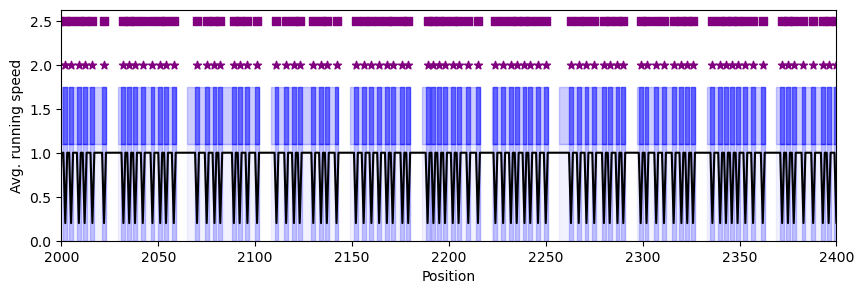

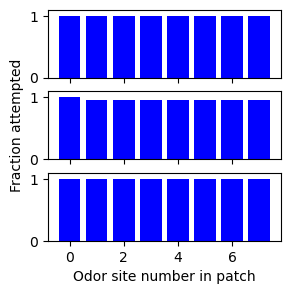

In [983]:
plot_sesson(
    '../data/rl_agent_outputs/det_reward_to_stoch_long_trials_20k_updates_2024-08-23_09_29_05_372302/state',
    env_idx=9,
    update_num=3,
    xlim=(2000, 2400),
)

['00000.pkl', '00001.pkl', '00002.pkl', '00003.pkl', '00004.pkl', '00005.pkl', '00006.pkl', '00007.pkl', '00008.pkl', '00009.pkl', '00010.pkl', '00011.pkl', '00012.pkl', '00013.pkl', '00014.pkl', '00015.pkl', '00016.pkl', '00017.pkl', '00018.pkl', '00019.pkl', '00020.pkl', '00021.pkl', '00022.pkl', '00023.pkl', '00024.pkl', '00025.pkl', '00026.pkl', '00027.pkl', '00028.pkl', '00029.pkl', '00030.pkl', '00031.pkl', '00032.pkl', '00033.pkl', '00034.pkl', '00035.pkl', '00036.pkl', '00037.pkl', '00038.pkl', '00039.pkl', '00040.pkl', '00041.pkl', '00042.pkl', '00043.pkl', '00044.pkl', '00045.pkl', '00046.pkl', '00047.pkl', '00048.pkl', '00049.pkl', '00050.pkl', '00051.pkl', '00052.pkl', '00053.pkl', '00054.pkl', '00055.pkl', '00056.pkl', '00057.pkl', '00058.pkl', '00059.pkl', '00060.pkl', '00061.pkl', '00062.pkl', '00063.pkl', '00064.pkl', '00065.pkl', '00066.pkl', '00067.pkl', '00068.pkl', '00069.pkl', '00070.pkl', '00071.pkl', '00072.pkl', '00073.pkl', '00074.pkl', '00075.pkl', '00076.pkl'

C:\Users\david.bell\AppData\Local\Temp\ipykernel_48936\1746405852.py:60: RuntimeWarning: divide by zero encountered in divide
  axs.plot(np.arange(len(all_dwell_times)), 1/np.array(all_dwell_times), c='black', zorder=0)


Patch count: 93
[16.05880786  0.53579138 27.57053554]


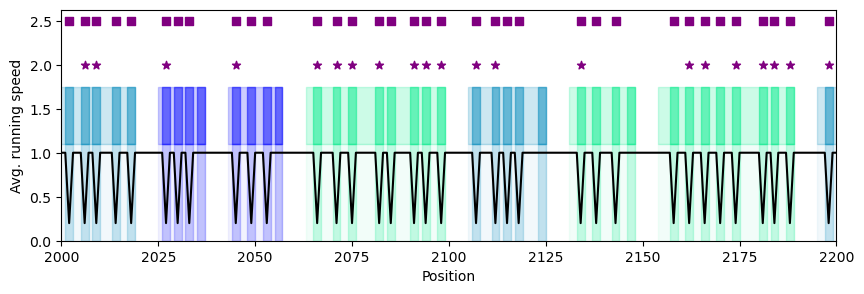

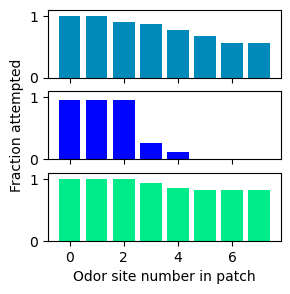

In [62]:
plot_sesson(
    '../data/rl_agent_outputs/det_reward_to_stoch_long_trials_max_reward_decay_30_2024-08-29_17_06_50_928811/state',
    env_idx=10,
    xlim=(2000, 2200),
    max_reward_param=30,
)

In [41]:
def plot_avg_stops_vs_reward_param(data_path, update_num=None, max_reward_param=10):

    indices = [] if update_num is None else [update_num]
    state_data = load_data(
        data_path,
        indices=indices,
    )

    d = state_data.__next__()

    cmap = mpl.colormaps['winter']

    scale = 1
    fig_sensitivity, axs_sensitivity = plt.subplots(4, 5, figsize=(8 * scale, 6 * scale), sharex=True, sharey=True)

    for env_idx in range(20):
        all_patch_bounds = []
        all_reward_site_bounds = []
        all_patch_nums = []
        all_actions = []
        all_positions = []
        all_rewards = []
        all_patch_reward_params = []
        all_current_reward_site_attempted = []
        all_obs = []
        
        for k in np.arange(len(d)):
            all_patch_bounds.append(d[k]['current_patch_bounds'][env_idx])
            all_reward_site_bounds.append(d[k]['reward_bounds'][env_idx])
            all_patch_nums.append(d[k]['current_patch_num'][env_idx])
            all_actions.append(d[k]['action'][env_idx])
            all_positions.append(d[k]['current_position'][env_idx])
            all_rewards.append(d[k]['reward'][env_idx])
            all_patch_reward_params.append(d[k]['patch_reward_param'][env_idx])
            all_current_reward_site_attempted.append(d[k]['current_reward_site_attempted'][env_idx])
            all_obs.append(d[k]['obs'][env_idx])
        
        all_dwell_times = []
        rewards_at_positions = [0]
        reward_attempted_at_positions = [False]
        dwell_time = 0
        last_p = None
        for i, p in enumerate(all_positions):
            if last_p is not None and (p != last_p):
                all_dwell_times.append(dwell_time)
                rewards_at_positions.append(0)
                reward_attempted_at_positions.append(False)
                dwell_time = 0
            if last_p is not None:
                dwell_time += 1
            rewards_at_positions[-1] += all_rewards[i]
            reward_attempted_at_positions[-1] = True if all_current_reward_site_attempted[i] else reward_attempted_at_positions[-1]
            last_p = p
        
        rewards_at_positions = np.array(rewards_at_positions)
        reward_attempted_at_positions = np.array(reward_attempted_at_positions)
        
        reward_param_of_stop = []
        site_idx_of_stop =  []
        site_stops_for_patch_type = np.zeros((np.array(all_patch_nums).max() + 1, 8))
        patches_entered_for_patch_type = np.zeros((np.array(all_patch_nums).max() + 1,))
        reward_param_for_patch_type = np.zeros((np.array(all_patch_nums).max() + 1,))
        
        last_pb = None
        patch_count = 0
        for i, pb in enumerate(all_patch_bounds):
            if last_pb is None or (pb != last_pb).any():
                patches_entered_for_patch_type[all_patch_nums[i]] += 1
                reward_param_for_patch_type[all_patch_nums[i]] = all_patch_reward_params[i]
                patch_count += 1
                pb_amended = pb.copy()
                for k_rwsb, rwsb in enumerate(all_reward_site_bounds[i]):
                    if np.sum(reward_attempted_at_positions[int(rwsb[0]):int(rwsb[1])]) == 0:
                        pb_amended[1] = rwsb[1]
                        break
                    else:
                        reward_param_of_stop.append(all_patch_reward_params[i])
                        site_idx_of_stop.append(k_rwsb)
                        site_stops_for_patch_type[all_patch_nums[i], k_rwsb] += 1
            last_pb = pb

        print(reward_param_for_patch_type)

        
        scale = 1
        fig, axs = plt.subplots(3, 1, figsize=(3 * scale, 3 * scale), sharex=True, sharey=True)
        # mx = site_stops_for_patch_type.max()

        avg_stops_for_patch_type = np.empty((site_stops_for_patch_type.shape[0],))
        
        x = np.arange(site_stops_for_patch_type.shape[1])
        for k in range(site_stops_for_patch_type.shape[0]):
            cdf = site_stops_for_patch_type[k, :] / patches_entered_for_patch_type[k]
            axs[k].bar(x, cdf, color=cmap(reward_param_for_patch_type[k] / max_reward_param))
            axs[k].set_ylim(0, 1.1)

            pdf = cdf - np.concatenate([cdf[1:], np.zeros(1)])
            # axs[k].bar(x, pdf, color=cmap(reward_param_for_patch_type[k] / max_reward_param))

            avg_stops_for_patch_type[k] = np.dot(pdf, x)

        axs[1].set_ylabel('Fraction attempted')
        axs[2].set_xlabel('Odor site number in patch')

        res = linregress(reward_param_for_patch_type, avg_stops_for_patch_type)

        x_linfit = np.linspace(reward_param_for_patch_type.min(), reward_param_for_patch_type.max(), 100)
        axs_sensitivity[int(env_idx / 5), env_idx % 5].plot(x_linfit, res.slope * x_linfit + res.intercept, lw=0.5, c='red')
        axs_sensitivity[int(env_idx / 5), env_idx % 5].scatter(reward_param_for_patch_type, avg_stops_for_patch_type, c='black')
        
    axs_sensitivity[0, 0].set_ylim(0)
    axs_sensitivity[0, 0].set_xlim(0, max_reward_param * 1.1)
    axs_sensitivity[1, 0].set_ylabel('Avg number of stops')
    axs_sensitivity[-1, 2].set_xlabel('Reward decay parameter')
            
    

['00000.pkl', '00001.pkl', '00002.pkl', '00003.pkl', '00004.pkl', '00005.pkl', '00006.pkl', '00007.pkl', '00008.pkl', '00009.pkl', '00010.pkl', '00011.pkl', '00012.pkl', '00013.pkl', '00014.pkl', '00015.pkl', '00016.pkl', '00017.pkl', '00018.pkl', '00019.pkl', '00020.pkl', '00021.pkl', '00022.pkl', '00023.pkl', '00024.pkl', '00025.pkl', '00026.pkl', '00027.pkl', '00028.pkl', '00029.pkl', '00030.pkl', '00031.pkl', '00032.pkl', '00033.pkl', '00034.pkl', '00035.pkl', '00036.pkl', '00037.pkl', '00038.pkl', '00039.pkl', '00040.pkl', '00041.pkl', '00042.pkl', '00043.pkl', '00044.pkl', '00045.pkl', '00046.pkl', '00047.pkl', '00048.pkl', '00049.pkl', '00050.pkl', '00051.pkl', '00052.pkl', '00053.pkl', '00054.pkl', '00055.pkl', '00056.pkl', '00057.pkl', '00058.pkl', '00059.pkl', '00060.pkl', '00061.pkl', '00062.pkl', '00063.pkl', '00064.pkl', '00065.pkl', '00066.pkl', '00067.pkl', '00068.pkl', '00069.pkl', '00070.pkl', '00071.pkl', '00072.pkl', '00073.pkl', '00074.pkl', '00075.pkl', '00076.pkl'

C:\Users\david.bell\AppData\Local\Temp\ipykernel_48936\4032439000.py:86: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  fig, axs = plt.subplots(3, 1, figsize=(3 * scale, 3 * scale), sharex=True, sharey=True)


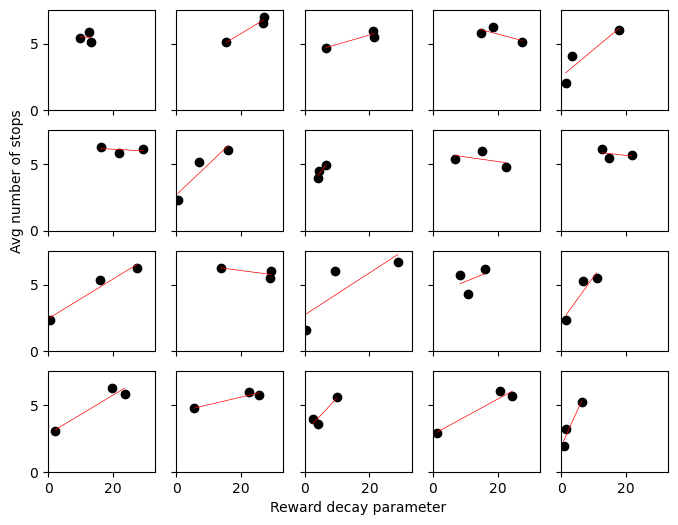

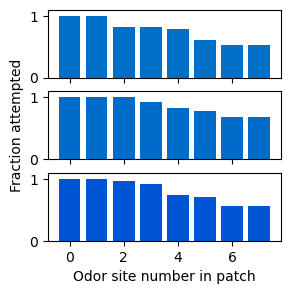

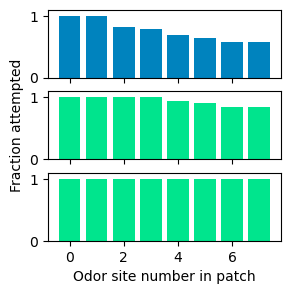

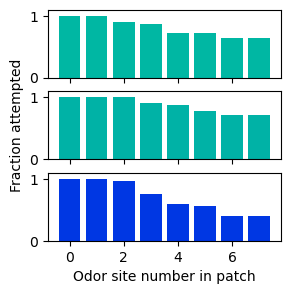

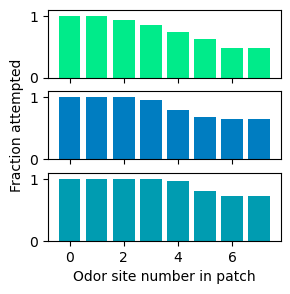

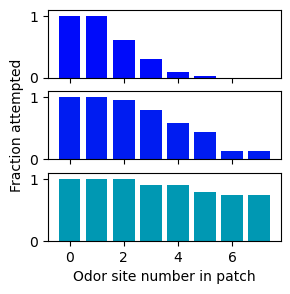

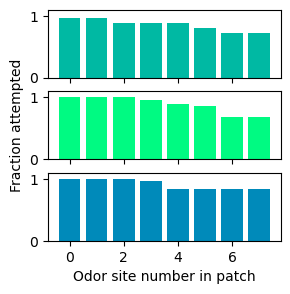

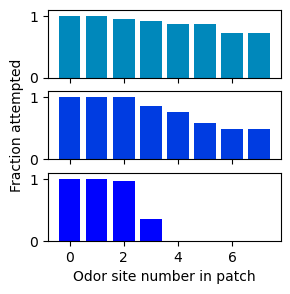

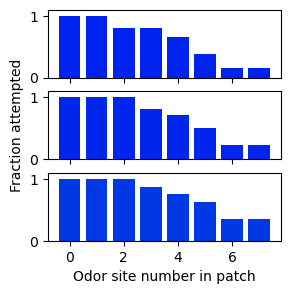

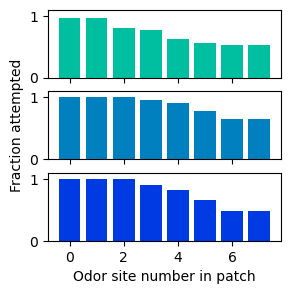

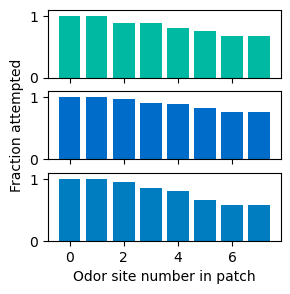

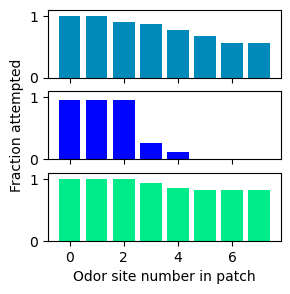

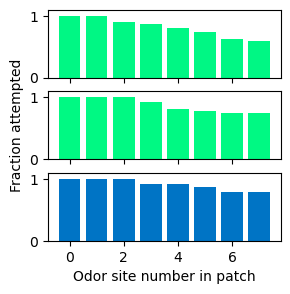

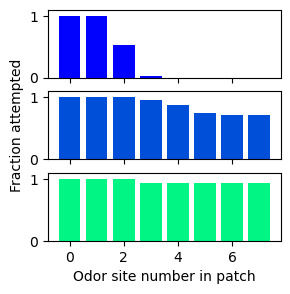

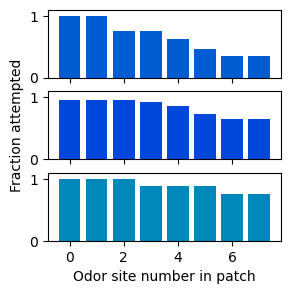

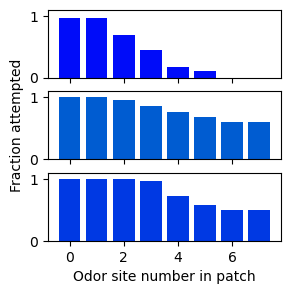

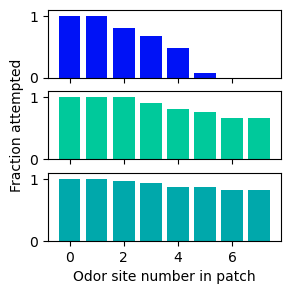

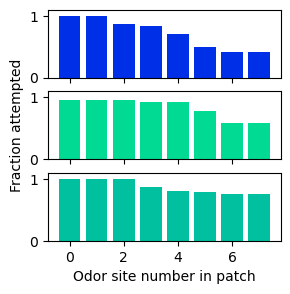

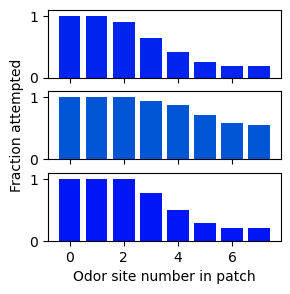

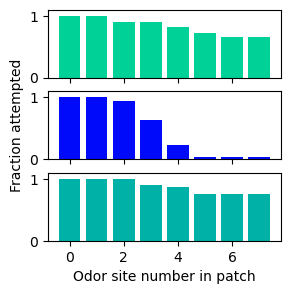

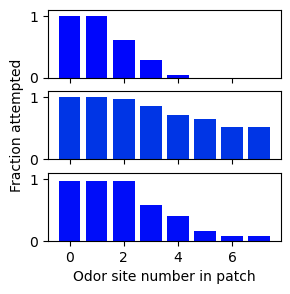

In [45]:
plot_avg_stops_vs_reward_param(
    '../data/rl_agent_outputs/det_reward_to_stoch_long_trials_max_reward_decay_30_2024-08-29_17_06_50_928811/state',
    max_reward_param=30,
)

['00000.pkl', '00001.pkl', '00002.pkl', '00003.pkl', '00004.pkl', '00005.pkl', '00006.pkl', '00007.pkl', '00008.pkl', '00009.pkl', '00010.pkl', '00011.pkl', '00012.pkl', '00013.pkl', '00014.pkl', '00015.pkl', '00016.pkl', '00017.pkl', '00018.pkl', '00019.pkl', '00020.pkl', '00021.pkl', '00022.pkl', '00023.pkl', '00024.pkl', '00025.pkl', '00026.pkl', '00027.pkl', '00028.pkl', '00029.pkl', '00030.pkl', '00031.pkl', '00032.pkl', '00033.pkl', '00034.pkl', '00035.pkl', '00036.pkl', '00037.pkl', '00038.pkl', '00039.pkl', '00040.pkl', '00041.pkl', '00042.pkl', '00043.pkl', '00044.pkl', '00045.pkl', '00046.pkl', '00047.pkl', '00048.pkl', '00049.pkl', '00050.pkl', '00051.pkl', '00052.pkl', '00053.pkl', '00054.pkl', '00055.pkl', '00056.pkl', '00057.pkl', '00058.pkl', '00059.pkl', '00060.pkl', '00061.pkl', '00062.pkl', '00063.pkl', '00064.pkl', '00065.pkl', '00066.pkl', '00067.pkl', '00068.pkl', '00069.pkl', '00070.pkl', '00071.pkl', '00072.pkl', '00073.pkl', '00074.pkl', '00075.pkl', '00076.pkl'

C:\Users\david.bell\AppData\Local\Temp\ipykernel_48936\4032439000.py:86: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  fig, axs = plt.subplots(3, 1, figsize=(3 * scale, 3 * scale), sharex=True, sharey=True)


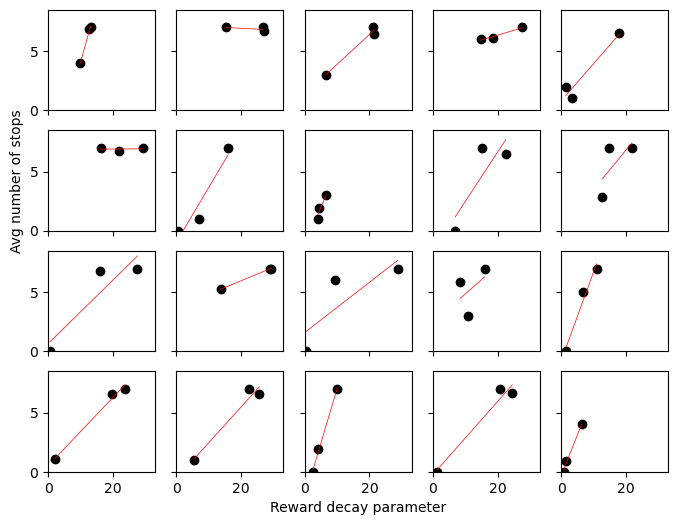

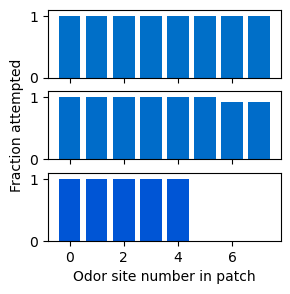

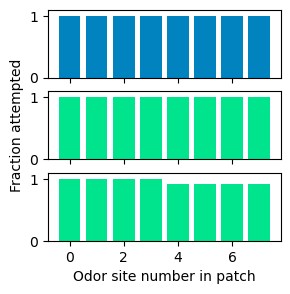

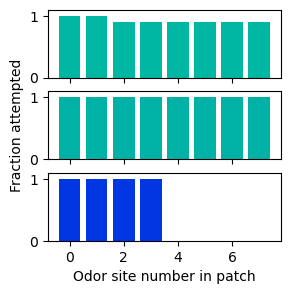

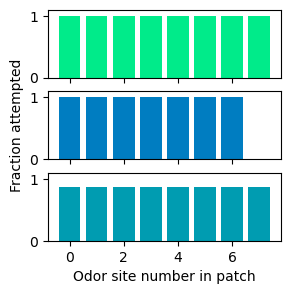

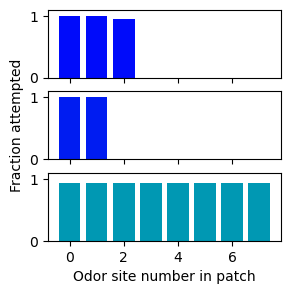

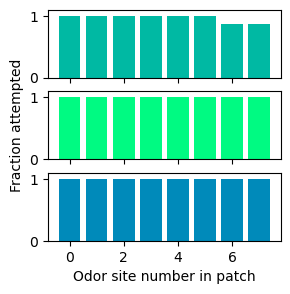

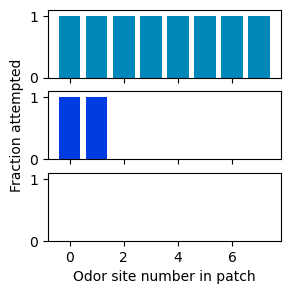

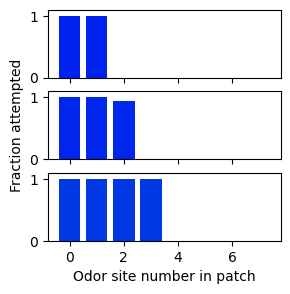

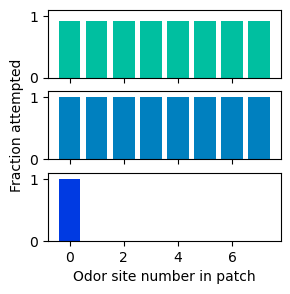

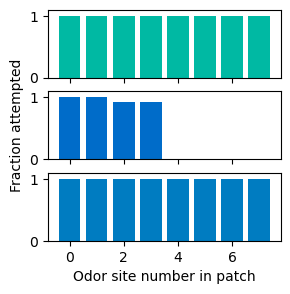

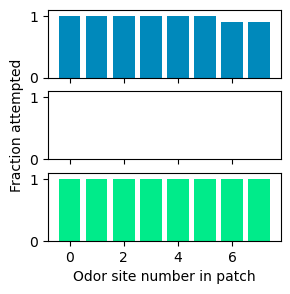

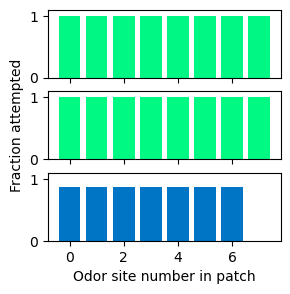

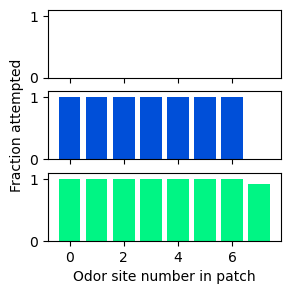

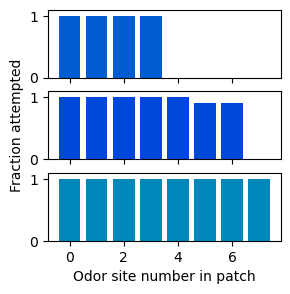

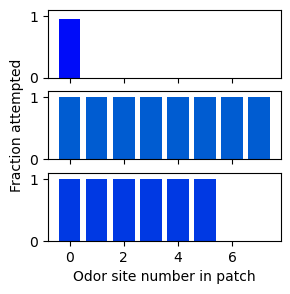

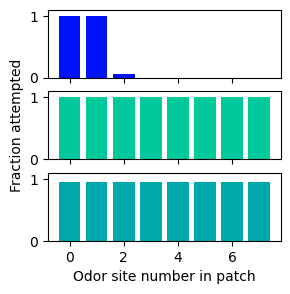

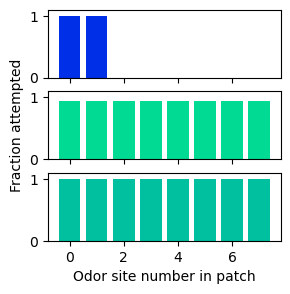

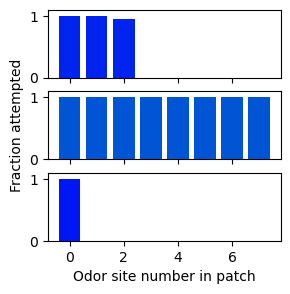

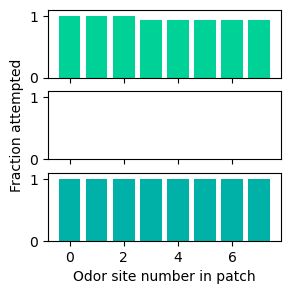

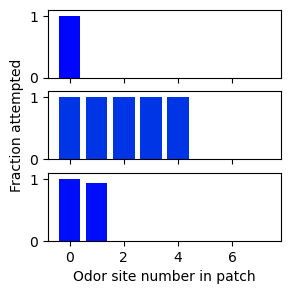

In [55]:
plot_avg_stops_vs_reward_param(
    '../data/grid_search_agent_outputs/expect_reward_to_stoch_long_trials_max_reward_decay_30_2024-08-30_12_32_24_721439/state',
    max_reward_param=30,
)